# Práctica: análisis de opinión en críticas hoteleras

<img src="img/bellagio.jpg" style="width:200x;height:150;">

Vamos a poner en práctica todo lo aprendido hasta el momento sobre un problema de análisis de críticas a hoteles. El conjunto de datos que utilizaremos es una extracción de Booking.com, disponible en formato original en [Kaggle](https://www.kaggle.com/jiashenliu/515k-hotel-reviews-data-in-europe).

## Instrucciones

A lo largo de este cuaderno encontrarás celdas vacías que tendrás que rellenar con tu propio código. Sigue las instrucciones del cuaderno y presta especial atención a los siguientes iconos:

<table>
<tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">Deberás responder a la pregunta indicada con el código o contestación que escribas en la celda inferior. Se te evaluará la práctica según la corrección de tu solución, así como por la calidad del código.</td></tr>
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">Esto es una pista u observación que te puede ayudar a resolver la práctica. No tienes que escribir en el cuaderno ninguna contestación a estos apartados, pero conviene que los hagas para entender los siguientes pasos.</td></tr>
 <tr><td width="80"><img src="img/pro.png" style="width:auto;height:auto"></td><td style="text-align:left">Este es un ejercicio avanzado y voluntario que puedes realizar si quieres profundar más sobre el tema. No se considerará para la evaluación de la práctica, pero te animamos a intentarlo para aprender más ¡Ánimo!</td></tr>
</table>

Adicionalmente si necesitas consultar la ayuda de cualquier función python puedes colocar el cursor de escritura sobre el nombre de la misma y pulsar Mayúsculas+Shift para que aparezca un recuadro con sus detalles. Ten en cuenta que esto únicamente funciona en las celdas de código.

¡Adelante!

## Entorno

Para realizar la práctica, debes usar el **entorno de conda utilizado en las clases de deeplearning**. Para instalarlo:

    conda env create -f environment-deeplearning.yml deeplearning-labs 
    conda ativate deeplearning-labs

Después de instalarlo, **asegurate de tener el kernel de jupyter fijado con este entorno recién instalado**. 

*(opcional)* Si quieres usar paquetes adiccionales de pyhton que no estén instalados en este entorno conda, puedes instarlarlos una vez este esté activado con el siguiente comando:

    conda install PACKAGENAME
    
Si el paquete corresponde al respositorio de Anaconda. Si no deberás usar

    pip install PACKAGENAME
    
Si decides añadir nuevos paquetes, debes listarlos a continuación e indicar la versión del nuevo paquete utilizada en tu entorno. La versión instalada puedes verla ejecutando `conda list` y buscando el paquete entre todos los instalados en ese entorno activado.

* Package1: ...
* ...

In [107]:
import matplotlib.pyplot as plt
%matplotlib inline

## Objetivo: Aplica lo aprendido

El objetivo de la práctica es utilizar los datos de entrenamiento para construir un clasificador automático que indique si una crítica de un hotel es favorable o desfavorable. Puedes utilizar cualquiera de las técnicas vistas durante el curso para este fin, aunque a continuación se piden una serie mínima de estrategias a emplear. Para medir la calidad del modelo de clasificación, puedes utilizar el conjunto de datos de test, pero es importante remarcar que estos datos **solo pueden utilizarse para medir el acierto del clasificador**. Esto implica que tampoco pueden emplearse los datos de test para realizar técnicas de validación cruzada o entrenar vectorizadores de textos.

Este problema es desbalanceado, ya que existen muchos más datos de críticas positivas que de críticas negativas. Por ello, usar la precisión o accuracy como métrica de la calidad del modelo **no es aconsejable**, ya que un modelo que clasifique todas críticas como positivas obtendrá una precisión muy alta, a pesar de su falta de utilidad en práctica. En su lugar deberá emplearse la métrica [roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html), que tiene en cuenta la importancia de ambas clases.

Para cada modelo, se deberá generar **la curva roc** y **elegir un threshold** adecuado con el cual poder ver **la matriz de confusión** para posteriormente poder comparar resultados entre todos los modelos realizados.

## Carga de datos

Para empezar vamos a cargar los datos de entrenamiento y test en memoria.

<table>
<tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">Carga los datos de <b>data/train.csv</b> y <b>data/test.csv</b> en DataFrames de Pandas con nombres <b>train</b> y <b>test</b>, respectivamente.</td></tr>
</table>

In [108]:
# Librerías usadas en el código

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.svm import LinearSVC
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import roc_auc_score, plot_roc_curve
import spacy

In [109]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

<table>
<tr><td width="80"><img src="img/pro.png" style="width:auto;height:auto"></td><td style="text-align:left">En <b>data/train.csv</b> solo se incluye una porción del conjunto de entrenamiento. Si quieres tratar de conseguir mayores niveles de acierto, puedes emplear el conjunto de entrenamiento completo disponible en <b>data/trainfull.csv</b>.</td></tr>
</table>

In [110]:
####### INSERT YOUR CODE HERE

trainfull = pd.read_csv('data/trainfull.csv')

## Exploración de datos

A continuación, explora los datos cargados previamente. Puedes ver el número de datos de cada clase, realizar gráficos comparando las columnas, ver si tenemos datos nulos...

In [111]:
####### INSERT YOUR CODE HERE
trainfull.head()

,Negative_Review,Positive_Review,Approves
0,I am so angry that i made this post available...,Only the park outside of the hotel was beauti...,False
1,My room was dirty and I was afraid to walk ba...,Great location in nice surroundings the bar a...,False
2,Apart from the price for the brekfast Everyth...,Good location Set in a lovely park friendly s...,True
3,Nothing all great,Rooms were stunningly decorated and really sp...,True
4,No Negative,This hotel is being renovated with great care...,True


In [112]:
test.head()

,Negative_Review,Positive_Review,Approves
0,No Negative,Breakfast was excellent Reception was very he...,True
1,Nothing,Big breakfast very big and comfortable room,True
2,No Negative,Superb as always,True
3,Would have like to stay longer will stay here...,Great brekkie catered for all 3 of us and gre...,True
4,No Negative,Everything,True


In [113]:
train.head()

,Negative_Review,Positive_Review,Approves
0,I am so angry that i made this post available...,Only the park outside of the hotel was beauti...,False
1,My room was dirty and I was afraid to walk ba...,Great location in nice surroundings the bar a...,False
2,Apart from the price for the brekfast Everyth...,Good location Set in a lovely park friendly s...,True
3,Nothing all great,Rooms were stunningly decorated and really sp...,True
4,No Negative,This hotel is being renovated with great care...,True


In [114]:
train.shape

(10000, 3)

In [115]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Modelos
### Modelo basado en caracteres

<table>
<tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">Construye un modelo de clasificación que en base a la crítica en texto de un hotel determine si esta es favorable o desfavorable, empleando únicamente características basadas en los caracteres del texto. Mide el nivel de acierto sobre el conjunto de test. ¿Qué nivel de precisión puedes alcanzar?</td></tr>
</table>

<table>
<tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">Ten en cuenta que cada crítica de hotel incluye dos campos de texto, <i>Negative_Review</i> y <i>Positive_Review</i>. Es recomendable que construyas un modelo que analice ambos textos para tomar la decisión. Puedes construir un Pipeline que tenga en cuenta ambas entradas de datos usando <a href=https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html>ColumnTransformer</a></td></tr>
</table>

In [116]:
ct = ColumnTransformer(
    [
        ("vectorizer_negative", HashingVectorizer(ngram_range=(1,1), analyzer="char"), 'Negative_Review'),
        ("vectorizer_positive", HashingVectorizer(ngram_range=(1,1), analyzer="char"), 'Positive_Review'),
    ]
)

# La matriz obtenida tendrá por cada fila, los valores transformados de las dos reviews, creando un espacio de una única feature, que en realidad está representando ambas reviews.
# Ahora entrenamos el modelo vectorizador y transformamos los datos de train que van a pasar al modelo para entrenarlo.
ct.fit(train)
data_train_tr = ct.transform(train)

# Entrenamos el modelo, con los datos de train
model = LinearSVC()
model.fit(data_train_tr, train['Approves'])

# Ahora para poder saber como de bueno es nuestro modelo, pasamos los datos de test (transformados por nuestro vectorizador ya entrenado con los datos de train) al modelo para que prediga
data_test_tr = ct.transform(test)
y_pred =  model.predict(data_test_tr)

# De ahí sacamos la score roc_auc
print("El score AUC-ROC del modelo es:", roc_auc_score(y_pred, test['Approves']))

El score AUC-ROC del modelo es: 0.8763994593918363


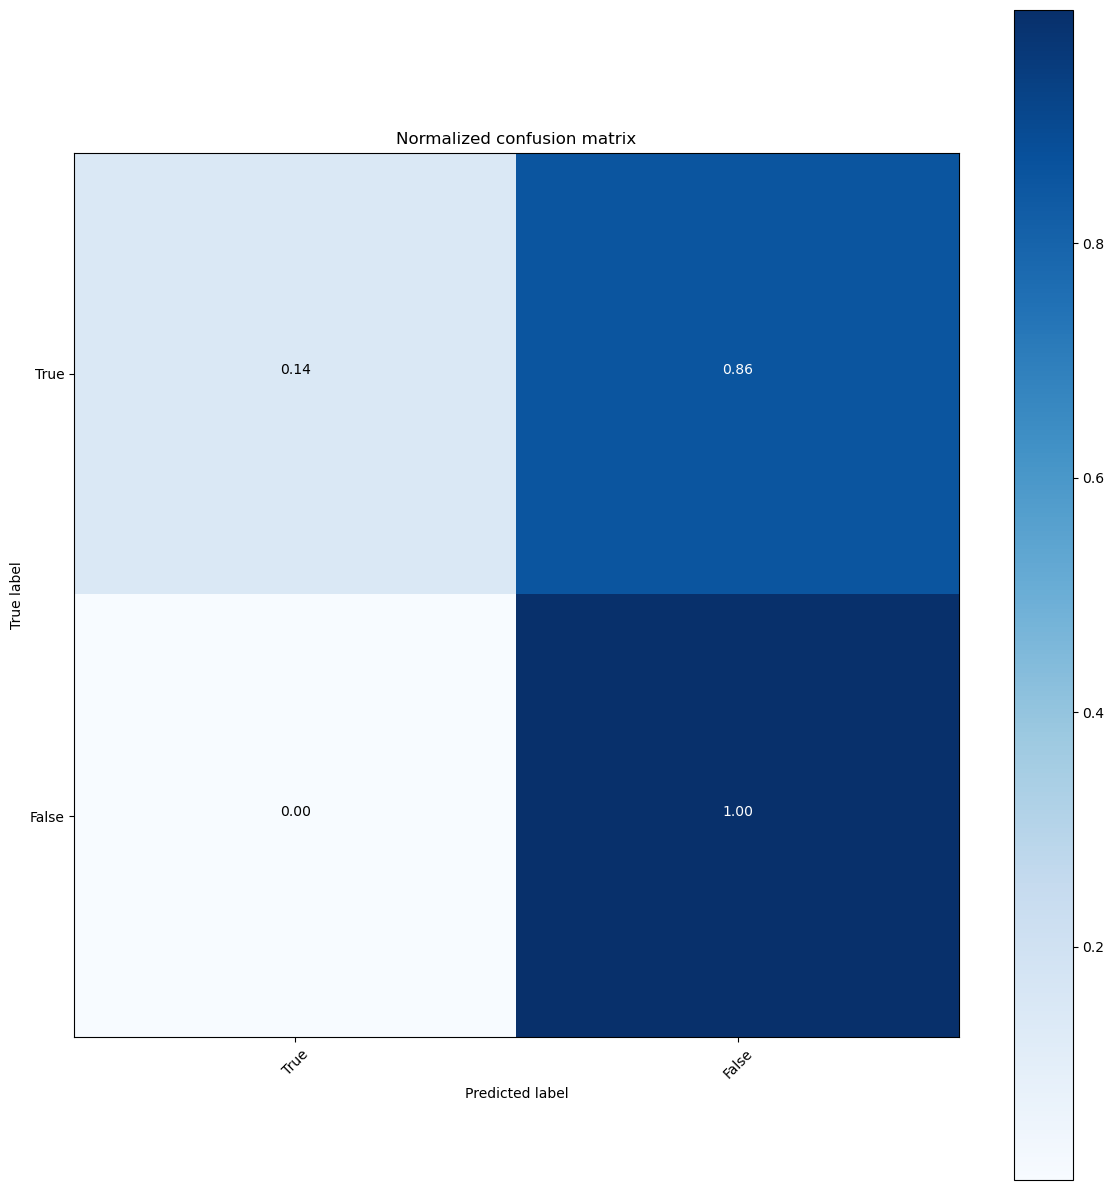

In [117]:
cnf_matrix = confusion_matrix(test['Approves'], y_pred)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=["True", "False"], normalize=True, title='Normalized confusion matrix')
plt.show()

### Modelo basado en tokens (palabras)

<table>
<tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">Construye un modelo de clasificación que en base a la crítica en texto de un hotel determine si esta es favorable o desfavorable, empleando únicamente características basadas en los tokens del texto. Mide el nivel de acierto sobre el conjunto de test. ¿Qué nivel de precisión puedes alcanzar?</td></tr>
</table>

In [118]:
####### INSERT YOUR CODE HERE

ct = ColumnTransformer(
    [
        ("vectorizer_negative", HashingVectorizer(ngram_range=(1,1), analyzer="word"), 'Negative_Review'),
        ("vectorizer_positive", HashingVectorizer(ngram_range=(1,1), analyzer="word"), 'Positive_Review'),
    ]
)

ct.fit(train)
data_train_tr = ct.transform(train)


model = LinearSVC()
model.fit(data_train_tr, train['Approves'])

data_test_tr = ct.transform(test)
y_pred =  model.predict(data_test_tr)

print("El score AUC-ROC del modelo es:", roc_auc_score(y_pred, test['Approves']))

El score AUC-ROC del modelo es: 0.8783663822787185


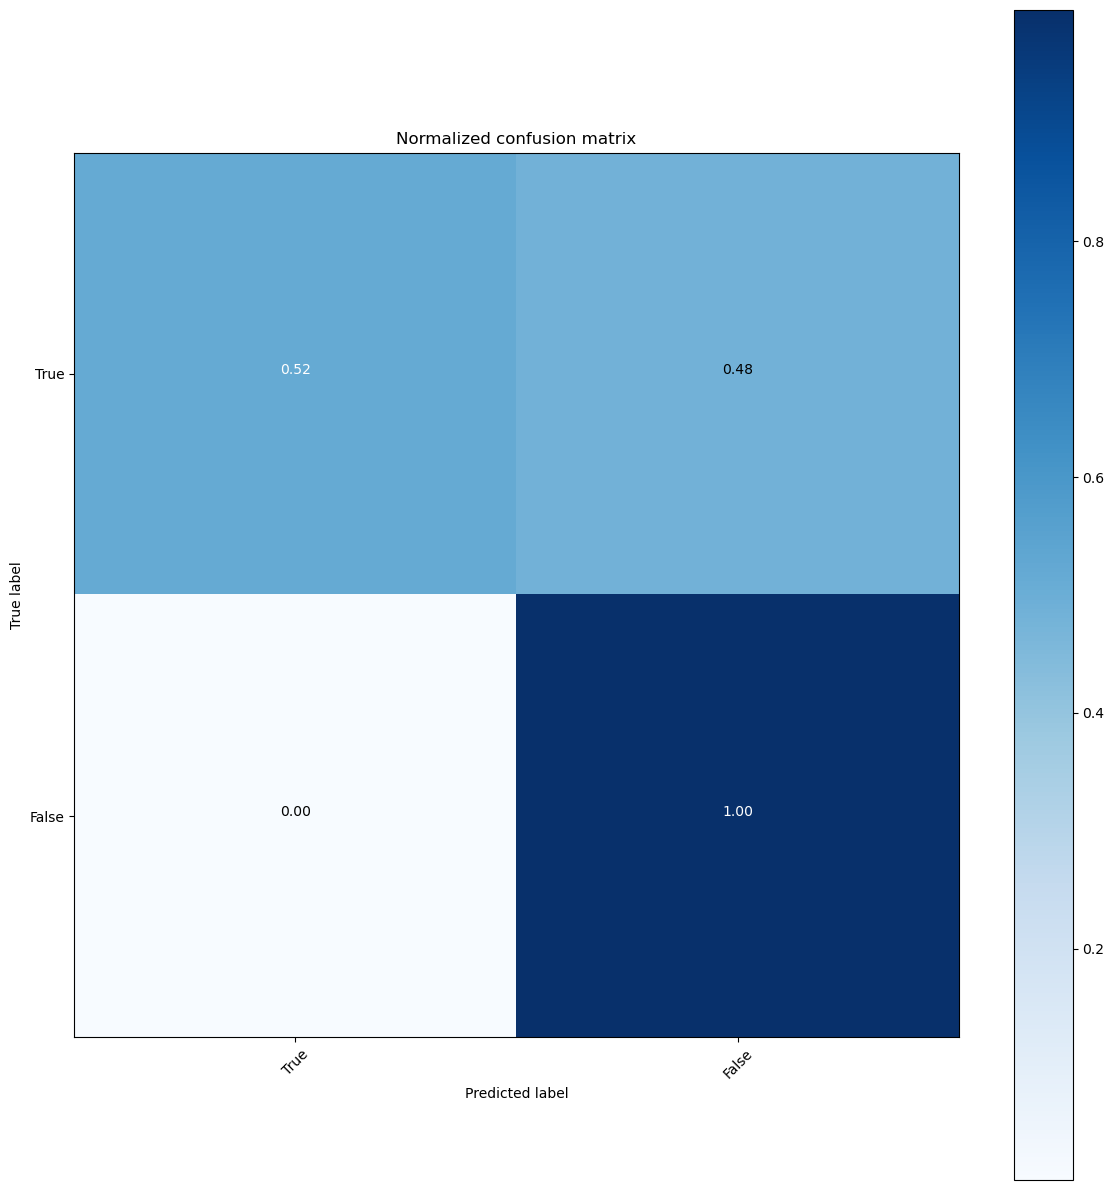

In [119]:
cnf_matrix = confusion_matrix(test['Approves'], y_pred)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=["True", "False"], normalize=True, title='Normalized confusion matrix')
plt.show()

### Modelo basado en análisis morfosintáctico

<table>
<tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">Construye un modelo de clasificación que en base a la crítica en texto de un hotel determine si esta es favorable o desfavorable, empleando algún tipo de análisis morfosintáctico (como n-gramas de lemas, o filtros por POS o stopwords). Mide el nivel de acierto sobre el conjunto de test. ¿Qué nivel de precisión puedes alcanzar?</td></tr>
</table>

<table>
<tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">Recuerda que es posible acelerar el análisis morfosintáctico desactivando ciertas componentes del modelo nlp de spaCy. Revisa el notebook del ejercicio correspondiente para recordar cómo.</td></tr>
</table>

In [120]:
####### INSERT YOUR CODE HERE
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

def token_morfosint_filter(df, fields):
    for field in fields:
        new_field = 'nlp_' + field
        df[new_field] = pd.Series([nlp(text) for text in df[field]], index=df.index)

        posfilter = [" ".join([token.lemma_ for token in text 
                                if token.pos_ in {"NOUN", "VERB", "ADJ", "ADV"} and not token.is_stop]) 
                        for text in df[new_field]]

        df['posfilter_' + field] = pd.Series(posfilter, index=df.index)

        # Eliminamos la columna que tokeniza el texto de los documentos, ya que nos quedamos con la información relevante en los campos posfilter_*
        df.drop(new_field, inplace=True, axis=1)


In [121]:
####### INSERT YOUR CODE HERE
token_morfosint_filter(train, train.columns[:2])
token_morfosint_filter(test, test.columns[:2])

In [122]:
pipe = Pipeline([
    ("ct", ColumnTransformer(
        [
            ("vectorizer_negative", HashingVectorizer(ngram_range=(1,1), analyzer="word"), 'posfilter_Negative_Review'),
            ("vectorizer_positive", HashingVectorizer(ngram_range=(1,1), analyzer="word"), 'posfilter_Positive_Review'),
        ]
    )),
    ("svm", LinearSVC())
])

# Entrenamos el modelo
pipe.fit(train,train['Approves'])

data_test_tr = pipe.named_steps['ct'].transform(test)
y_pred =  model.predict(data_test_tr)


El score AUC-ROC del modelo es: 0.8504342376219894


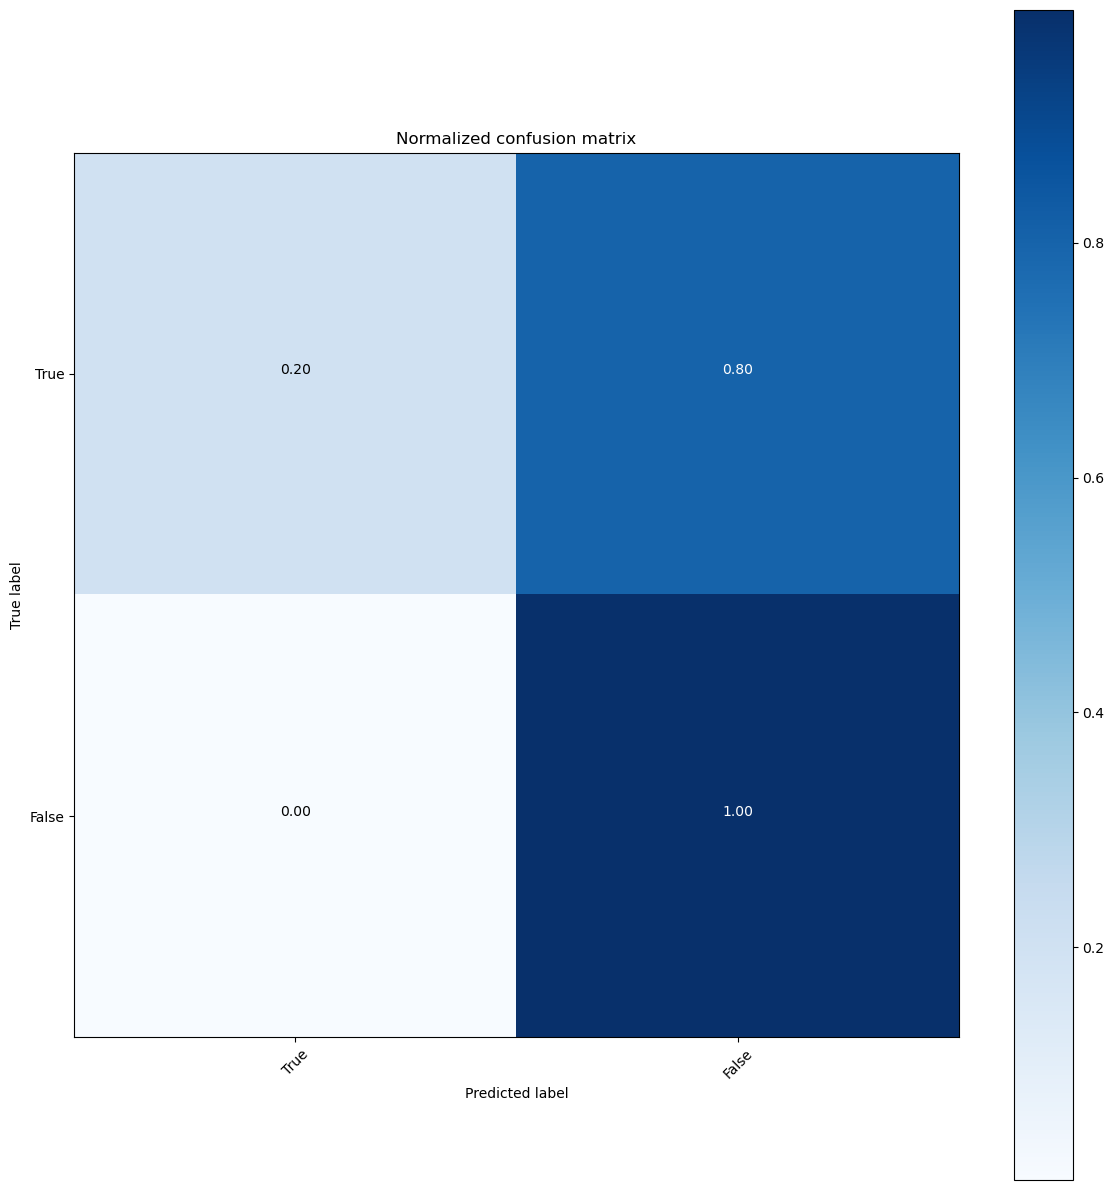

In [123]:
print("El score AUC-ROC del modelo es:", roc_auc_score(y_pred, test['Approves']))

cnf_matrix = confusion_matrix(test['Approves'], y_pred)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=["True", "False"], normalize=True, title='Normalized confusion matrix')
plt.show()

### Modelo basado en Deep Learning

<table>
<tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">Construye un modelo de clasificación que en base a la crítica en texto de un hotel determine si esta es favorable o desfavorable, empleando una aproximación basada en Embeddings y algún tipo de modelo de mezcla (CNN, LSTM, GRU, ...). Mide el nivel de acierto sobre el conjunto de test. ¿Qué nivel de precisión puedes alcanzar?</td></tr>
</table>

In [124]:
####### INSERT YOUR CODE HERE

In [125]:
####### INSERT YOUR CODE HERE

In [126]:
print("El score AUC-ROC del modelo es:", roc_auc_score(y_pred, test['Approves']))

cnf_matrix = confusion_matrix(test['Approves'], y_pred)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=["True", "False"], normalize=True, title='Normalized confusion matrix')
plt.show()

## Otras aproximaciones

<table>
<tr><td width="80"><img src="img/pro.png" style="width:auto;height:auto"></td><td style="text-align:left">Intenta mezclar varias de las features de puntos anteriores en un único modelo, o probar otras aproximaciones. ¿Puedes conseguir un acierto aún mejor?</td></tr>
</table>

In [127]:
####### INSERT YOUR CODE HERE

## Informe

<table>
<tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">Escribe un informe explicando qué decisiones has tomado a la hora de diseñar el modelo, qué cosas has probado, qué ha funcionado y qué no. Además, realiza una tabla comparativa con los scores sobre el conjunto de test de todos los modelos realizados en la práctica indicando con cuál se ha conseguido mejores resultados.</td></tr>
</table>